In [1]:
import sys
base_dir = "/Users/gsa0081/Projects/anylytics"
if base_dir not in sys.path:
    sys.path.append(base_dir)
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
import matplotlib.pyplot as plt
from earth_colors.utils.common import fig
from scipy import ndimage
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from earth_colors.utils.STRTools import str_map, str_parallel, setTQDMNotebook, str_groupBy
from itertools import count
from tqdm import tqdm
sns.set_style("white")
setTQDMNotebook()

In [11]:
imagedir = "/Users/gsa0081/Projects/anylytics/earth_colors/images"
#imageFiles = filter(lambda x: '201610' in x or '201606' in x, sorted(glob("%s/*.jpg" % imagedir)))
imageFiles = sorted(glob("%s/*.jpg" % imagedir))
images = (ndimage.imread(imageName,mode='RGB') for imageName in imageFiles)

In [12]:
def computeKMeans(image):
    clt = KMeans(n_clusters = 3)
    imReshaped = image.reshape((image.shape[0] * image.shape[1], 3))
    clt.fit(imReshaped)
    
    groups = str_groupBy(clt.labels_, key=lambda x: x)
    hist = [len(groups[i])/float(clt.labels_.size) for i in range(3)]
    return clt.cluster_centers_/255., hist

In [13]:
kMeans_output = str_parallel(computeKMeans, total=len(imageFiles), chunksize=10)(images)

In [14]:
def parseOutput(inp):
    colors, ratio = inp
    data = np.zeros((100,1,3))
    p1 = int(np.round(ratio[0]*100))
    p2 = int(p1 + np.round(ratio[1]*100))
    
    data[0:p1,0] = colors[0]
    data[p1:p2,0] = colors[1]
    data[p2:100,0] = colors[2]
    return data


In [15]:
ratio_output = np.squeeze(np.array(str_map(parseOutput)(kMeans_output)))

In [16]:
ratio_output.shape

(379, 100, 3)

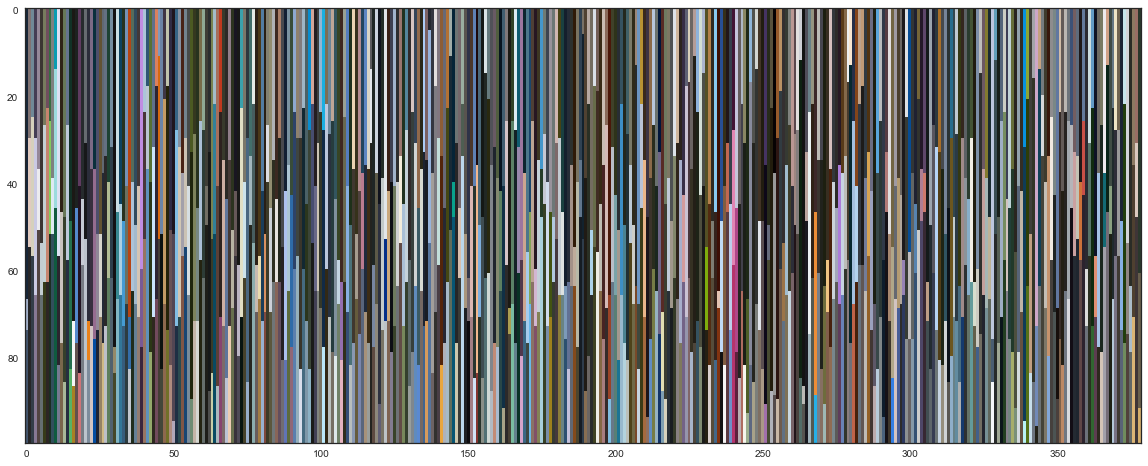

In [17]:
fig(figsize=(20,8))
plt.imshow(np.swapaxes(ratio_output,0,1),aspect='auto')

In [10]:
map(lambda x: '201610' in x , imageFiles).index(True)

28